In [24]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn import datasets, linear_model
import sys
import itertools
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict
import math

In [25]:
sns.set_style("white")
sns.set_context("paper")

def figsize(fig_width_pt=None, fig_height_pt=None):
    
    if fig_width_pt is None:
        fig_width_pt = 469.755 # Get this from LaTeX using \the\textwidth
        
    inches_per_pt = 1.0/72.27
    fig_width_pt = fig_width_pt*inches_per_pt  # Convert pt to inch

    if fig_height_pt is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height_pt = fig_width_pt*golden_mean # height in inches
        
    fig_size = [fig_width_pt,fig_height_pt]
    return fig_size

In [26]:
nomi_sensati_jb = {
    'LUM5_single': 'Single use entropy',
    'mdist_nres_daily': 'Mean dist. nearest daily-use POI',
    'nig_rat_daily': 'Ratio night life places and total POIs',
    'hType_mix2': 'Housing type entropy',
    
    'avg_block_area': 'Average block area',
    'num_intersect': 'Intersections density',
    'num_community_places': 'ratio third places - POIs',
    
    'bld_entr_age': 'Entropy build. age',
    'bld_entr_interiors': 'Entropy build. interiors',
    'enterprises_entr_size': 'Entropy enterprises size',
    'enterprises_empl_size': 'Avg employees per company',
    
    'bld_rat_int': 'ratio internal ap. and num buildings',
    'pop_rat_num': 'ratio num people and area',
    'emp_rat_num': 'Employment density',
    'emp_rat_pop': 'ratio pop density and employment density',
    'bld_rat_area': 'ratio buildings area and total area',
    
    'bor_rat_area': 'ratio vacuums area and total area',
    'mdist_parks': 'Avg distance blocks - parks',
    'mdist_smallparks': 'Avg distance blocks - small parks',
    'mdist_railways': 'Avg distance blocks - railways',
    'mdist_highways': 'Avg distance blocks - highways',
    'mdist_water': 'Avg distance blocks - water',
    
    
    'den_nres_daily': 'den_nres_daily',
    'den_nres_non-daily': 'den_nres_non-daily',
    'bld_std_age': 'bld_std_age'
}

nomi_sensati_mobile = {
    'avg_activity': 'Average activity',
    'avg_activity_day': 'Average activity (daytime)',
    'avg_activity_night': 'Average activity (night-time)',
}

nomi_sensati = {**nomi_sensati_jb, **nomi_sensati_mobile}

# Regressions and model selection

In [27]:
df = pd.read_csv('generated_files/merged_dataset_lesson.csv')
df.head()

,pro_com,ace,area_filtr,area,LUM5_single,mdist_nres_daily,nig_rat_daily,hType_mix2,avg_block_area,num_intersect,...,bor_rat_area,mdist_parks,mdist_smallparks,mdist_railways,mdist_highways,mdist_water,den_nres_daily,den_nres_non-daily,bld_std_age,activity_density
0,82053,1,2.294074e+06,2526490.0,0.834913,0.038478,0.314583,4.370384,9.041353,0.000462,...,0.000000,0.000514,0.004521,0.001087,0.000354,0.000731,0.000109,0.000066,17.938808,0.008260
1,82053,5,6.717292e+05,841640.0,0.997769,0.018261,0.020000,4.737226,9.349222,0.000194,...,0.131742,0.000412,0.002291,0.003341,0.000491,0.001654,0.000040,0.000009,12.311657,0.008072
2,82053,6,1.583958e+06,1619940.0,0.671734,0.009868,0.111111,4.065773,9.701084,0.000090,...,0.003436,0.000284,0.002465,0.002333,0.000746,0.001097,0.000013,0.000003,10.233967,0.003594
3,82053,7,1.092818e+06,1098970.0,0.558117,0.009960,0.000000,3.403636,9.943522,0.000062,...,0.000000,0.000203,0.001042,0.001182,0.000852,0.000889,0.000008,0.000000,10.451775,0.001571
4,82053,8,1.665450e+06,1665450.0,0.613831,0.003942,0.100000,3.434889,10.437003,0.000028,...,0.226589,0.000262,0.000956,0.005248,0.002158,0.000614,0.000006,0.000002,9.903861,0.002417


I import some code to have p-values (from https://gist.github.com/brentp/5355925)

In [28]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

## Regression

### Variables transformation

Text(0, 0.5, 'Activity Density')

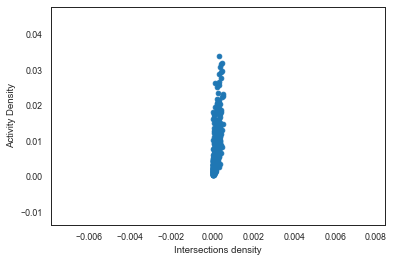

In [29]:
plt.scatter(df['num_intersect'], df['activity_density'])
plt.xlabel("Intersections density")
plt.ylabel("Activity Density")

Text(0, 0.5, 'log Activity Density')

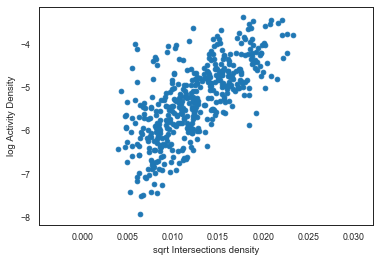

In [30]:
plt.scatter(np.power(df['num_intersect'], 0.5), np.log(df['activity_density']))
plt.xlabel("sqrt Intersections density")
plt.ylabel("log Activity Density")

In [31]:
# Load the diabetes dataset
trans_df = df[df.ace >= 0].sort_values('ace').copy()

models = ('land_use', 'small_blocks', 'aged_buildings', 'concetration', 'vacuums', 'optimized')

models_attributes = {
    'large':[
        'LUM5_single',
        'hType_mix2',
        'mdist_nres_daily',
        'mdist_smallparks',
    
        'num_intersect',
            
        'pop_rat_num',
        'emp_rat_num',
        'bld_std_age',
        'mdist_parks',
        'mdist_railways',
        'mdist_highways',
]
    
}

################## LARGE #################

attributes = models_attributes['large']

dataset_columns = set(trans_df.columns)

if 'LUM5_single' in dataset_columns:
    trans_df.loc[:, 'LUM5_single'] = stats.boxcox((1+np.max(trans_df['LUM5_single'])) - trans_df['LUM5_single'])[0]
if 'mdist_nres_daily' in dataset_columns:
    trans_df.loc[:, 'mdist_nres_daily'] = stats.boxcox(trans_df['mdist_nres_daily'])[0]
if 'nig_rat_daily' in dataset_columns:
    trans_df.loc[:, 'nig_rat_daily'] = stats.boxcox(trans_df['nig_rat_daily']+sys.float_info.epsilon)[0]
if 'hType_mix2' in dataset_columns:
    trans_df.loc[:, 'hType_mix2'] = stats.boxcox(trans_df['hType_mix2'])[0] #stats.boxcox((1+np.max(trans_df['hType_mix'])) - trans_df['hType_mix'])[0] #+sys.float_info.epsilon, 0.5)
if 'mdist_smallparks' in dataset_columns:
    trans_df.loc[:, 'mdist_smallparks'] = stats.boxcox(trans_df['mdist_smallparks'])[0]

if 'num_intersect' in dataset_columns:
    trans_df.loc[:, 'num_intersect'] = np.power(trans_df['num_intersect'], 0.5)
if 'avg_block_area' in dataset_columns:
    trans_df.loc[:, 'avg_block_area'] = stats.boxcox(trans_df['avg_block_area'])[0]

if 'bld_rat_int' in dataset_columns:
    trans_df.loc[:, 'bld_rat_int'] = stats.boxcox(trans_df['bld_rat_int'])[0]
if 'pop_rat_num' in dataset_columns:
    trans_df.loc[:, 'pop_rat_num'] =  stats.boxcox(trans_df['pop_rat_num'])[0]
if 'emp_rat_num' in dataset_columns:
    trans_df.loc[:, 'emp_rat_num'] = stats.boxcox(trans_df['emp_rat_num'])[0]
if 'emp_rat_pop' in dataset_columns:
    trans_df.loc[:, 'emp_rat_pop'] = stats.boxcox(trans_df['emp_rat_pop'])[0]

if 'bld_std_age' in dataset_columns:
    trans_df.loc[:, 'bld_std_age'] = stats.boxcox(trans_df['bld_std_age'])[0]

if 'mdist_parks' in dataset_columns:
    trans_df.loc[:, 'mdist_parks'] = stats.boxcox(trans_df['mdist_parks'])[0]
if 'mdist_railways' in dataset_columns:
    trans_df.loc[:, 'mdist_railways'] = stats.boxcox(trans_df['mdist_railways'])[0]
if 'mdist_highways' in dataset_columns:
    trans_df.loc[:, 'mdist_highways'] = stats.boxcox(trans_df['mdist_highways'])[0]
if 'mdist_water' in dataset_columns:
    trans_df.loc[:, 'mdist_water'] = stats.boxcox(trans_df['mdist_water'])[0]

# Feature normalization
trans_df[attributes] = preprocessing.scale(trans_df[attributes])


# If you want to add the iterations between variables
#for c1, c2 in itertools.combinations(columns, 2):
#    trans_df[c1+"_"+c2] = trans_df[c1]*trans_df[c2]
#    attributes.append(c1+"_"+c2)

attributes_all = attributes[:]

#ATTENZIONE: NEL LARGE, TOGLIERE QUESTO
#trans_df[attributes] = preprocessing.scale(trans_df[attributes])  

### Regression

In [32]:
X = trans_df[attributes]
Y = np.log(trans_df[['activity_density']])

# Create linear regression object
regr = LinearRegression(normalize=False,fit_intercept=True) 

kfold = ShuffleSplit(X.shape[0], test_size=0.25)
scores = [regr.fit(X.values[train], Y.values[train]).score(X[attributes].values[test], Y.values[test]) for train, test in kfold.split(X)]

print('Variance score: %.2f' % np.mean(scores))
print("Adjusted r2 {0:.2f}".format(np.mean([r2 - (1.-r2)* (len(attributes) / (X.shape[0]*0.75-len(attributes)-1.)) for r2 in scores])))
print()
fits = [regr.fit(X.values[train], Y.values[train]) for train, test in kfold.split(X)]
r2s = [f.p for f in fits]
print("p-values:", np.mean(r2s, axis=0))
print("p-values alti:", [attributes[i] for (i, x) in enumerate(np.mean(r2s, axis=0)[0]) if x > 0.05])
print()
r2s = [f.coef_ for f in fits]
print("Coefficients:", np.mean(r2s, axis=0))
print()
inter = [f.intercept_ for f in fits]
print("Coefficients:", np.mean(inter, axis=0))
print("Attributes:", attributes)

Variance score: 0.74
Adjusted r2 0.73

p-values: [[4.80956009e-03 1.28347205e-06 5.77646289e-01 3.42466174e-04
  2.68849173e-02 4.19694909e-04 0.00000000e+00 1.89403143e-01
  3.26698219e-07 1.82632803e-02 1.02970220e-02]]
p-values alti: ['mdist_nres_daily', 'bld_std_age']

Coefficients: [[-0.08223037  0.2046954   0.02941445 -0.14124787  0.11136331  0.13939381
   0.4539074   0.04084192 -0.17617863 -0.06085548 -0.07199852]]

Coefficients: [-5.29794795]
Attributes: ['LUM5_single', 'hType_mix2', 'mdist_nres_daily', 'mdist_smallparks', 'num_intersect', 'pop_rat_num', 'emp_rat_num', 'bld_std_age', 'mdist_parks', 'mdist_railways', 'mdist_highways']


In [33]:
regr_all = LinearRegression(normalize=False,fit_intercept=True)
regr_all.fit(trans_df[attributes].values, Y.values)
betas_dict = {a:b for a,b in zip(attributes, regr_all.coef_[0, :])}

print("Betas", list(zip(attributes, [round(x, 4) for x in regr_all.coef_[0,:]])))
print()
print("score", round(regr_all.score(trans_df[attributes].values, Y.values), 4))

Betas [('LUM5_single', -0.079), ('hType_mix2', 0.1717), ('mdist_nres_daily', 0.0591), ('mdist_smallparks', -0.1624), ('num_intersect', 0.1276), ('pop_rat_num', 0.1495), ('emp_rat_num', 0.4192), ('bld_std_age', 0.0346), ('mdist_parks', -0.1673), ('mdist_railways', -0.0609), ('mdist_highways', -0.0813)]

score 0.7631


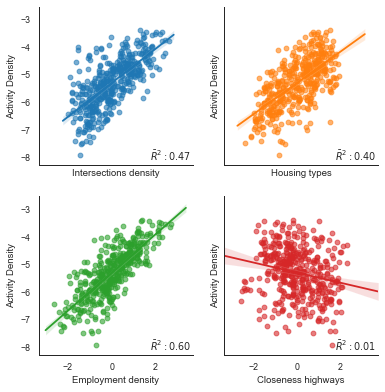

In [34]:
def r_square_in_plot(X,Y):
    regr_all = LinearRegression(normalize=False,fit_intercept=True)
    regr_all.fit(X.values, Y.values)
    r2 = regr_all.score(X.values, Y.values)
    adj = r2 - (1.-r2)* (len(attributes) / (trans_df.shape[0]*0.75-len(attributes)-1.))
    return adj

def mini_plot(ax, trans_df, Y, k, regr_all, color):
    ax.scatter(trans_df[k], Y, color = color, alpha=0.6)
    ax.plot(trans_df[k], regr_all.intercept_+trans_df[k]*betas_dict[k], color = color)
    ax.set_xlabel(nomi_sensati[k])
    ax.set_ylabel("Activity Density")

figsize_fit = figsize(440.0)
figsize_fit[1] = figsize_fit[1]*1.7
f, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=figsize_fit)
tovis = pd.DataFrame({'x': trans_df['num_intersect'], 'y':Y['activity_density']})
sns.regplot('x', 'y', tovis, fit_reg=True,scatter_kws={'alpha':0.6}, ax=ax[0,0])
ax[0,0].set_xlabel("Intersections density")
ax[0,0].set_ylabel("Activity Density")
ax[0,0].annotate(r"$\bar R^2: {0:.2f}$".format(r_square_in_plot(trans_df[['num_intersect']], Y)), xy=(1, 0), xycoords='axes fraction',xytext=(-2, 2), textcoords='offset points', horizontalalignment='right', verticalalignment='bottom')

tovis = pd.DataFrame({'x': trans_df['hType_mix2'], 'y':Y['activity_density']})
sns.regplot('x', 'y', tovis, fit_reg=True,scatter_kws={'alpha':0.6}, ax=ax[0,1])
ax[0,1].set_xlabel("Housing types")
ax[0,1].set_ylabel("Activity Density")
ax[0,1].annotate(r"$\bar R^2: {0:.2f}$".format(r_square_in_plot(trans_df[['hType_mix2']], Y)), xy=(1, 0), xycoords='axes fraction',xytext=(-2, 2), textcoords='offset points', horizontalalignment='right', verticalalignment='bottom')

tovis = pd.DataFrame({'x': trans_df['emp_rat_num'], 'y':Y['activity_density']})
sns.regplot('x', 'y', tovis, fit_reg=True,scatter_kws={'alpha':0.6}, ax=ax[1,0])
ax[1,0].set_xlabel("Employment density")
ax[1,0].set_ylabel("Activity Density")
ax[1,0].annotate(r"$\bar R^2: {0:.2f}$".format(r_square_in_plot(trans_df[['emp_rat_num']], Y)), xy=(1, 0), xycoords='axes fraction',xytext=(-2, 2), textcoords='offset points', horizontalalignment='right', verticalalignment='bottom')

tovis = pd.DataFrame({'x': trans_df['mdist_highways'], 'y':Y['activity_density']})
sns.regplot('x', 'y', tovis, fit_reg=True,scatter_kws={'alpha':0.6}, ax=ax[1,1])
ax[1,1].set_xlabel("Closeness highways")
ax[1,1].set_ylabel("Activity Density")
ax[1,1].annotate(r"$\bar R^2: {0:.2f}$".format(r_square_in_plot(trans_df[['mdist_highways']], Y)), xy=(1, 0), xycoords='axes fraction',xytext=(-2, 2), textcoords='offset points', horizontalalignment='right', verticalalignment='bottom')
sns.despine()
#plt.savefig('figures/fit.pdf', format='pdf', dpi=300,bbox_inches='tight')

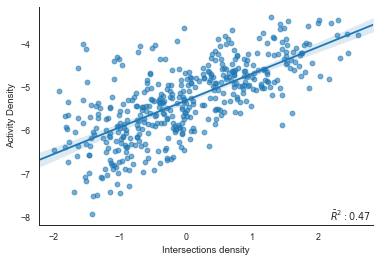

In [35]:
f, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,4))
tovis = pd.DataFrame({'x': trans_df['num_intersect'], 'y':Y['activity_density']})
sns.regplot('x', 'y', tovis, fit_reg=True,scatter_kws={'alpha':0.6}, ax=ax)
ax.set_xlabel("Intersections density")
ax.set_ylabel("Activity Density")
ax.annotate(r"$\bar R^2: {0:.2f}$".format(r_square_in_plot(trans_df[['num_intersect']], Y)), xy=(1, 0), xycoords='axes fraction',xytext=(-2, 2), textcoords='offset points', horizontalalignment='right', verticalalignment='bottom')
sns.despine()
#plt.savefig('figures/fit_pres.pdf', format='pdf', dpi=300,bbox_inches='tight')